<a href="https://colab.research.google.com/github/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Supp_Fig_10/Supp_Fig_10abc/explore_translation_codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore difference codes for the translation of amino acid and nucleotides sequences for translated alignment

In [1]:
%config InlineBackend.figure_format='retina'
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.spatial.distance import hamming
import pandas as pd

In [2]:
# Download the PalmDB RdRP amino acid sequences
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_rdrp_seqs.fa
palmdb = "palmdb_rdrp_seqs.fa"

--2023-12-11 03:56:54--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_rdrp_seqs.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35361991 (34M) [text/plain]
Saving to: ‘palmdb_rdrp_seqs.fa’

palmdb_rdrp_seqs.fa 100%[===================>]  33.72M   182MB/s    in 0.2s    

2023-12-11 03:56:55 (182 MB/s) - ‘palmdb_rdrp_seqs.fa’ saved [35361991/35361991]



### Plot occurence of each amino acid in PalmDB sequences

In [3]:
aa_list = ["F", "L", "I", "M", "V", "S", "P", "T", "A", "Y", "H", "Q", "N", "K", "D", "E", "C", "W", "R", "G", "X", "B", "J", "Z"]

aa_counts = []
for aa in aa_list:
    aa_count = !grep -v ">" $palmdb | grep -E -o $aa | wc -l
    print(aa_count[0])
    aa_counts.append(aa_count[0])

1669674
3330717
2014490
1059513
2185671
2490471
1004647
1821957
2190586
1367696
721647
899409
1393701
1316330
2326077
1436448
765127
578413
1639554
2257148
38048
49
31
15


In [6]:
df = pd.DataFrame()
df["aa"] = aa_list
df["aa_count"] =  np.array(aa_counts).astype(int)
df = df.sort_values("aa_count", ascending=False)

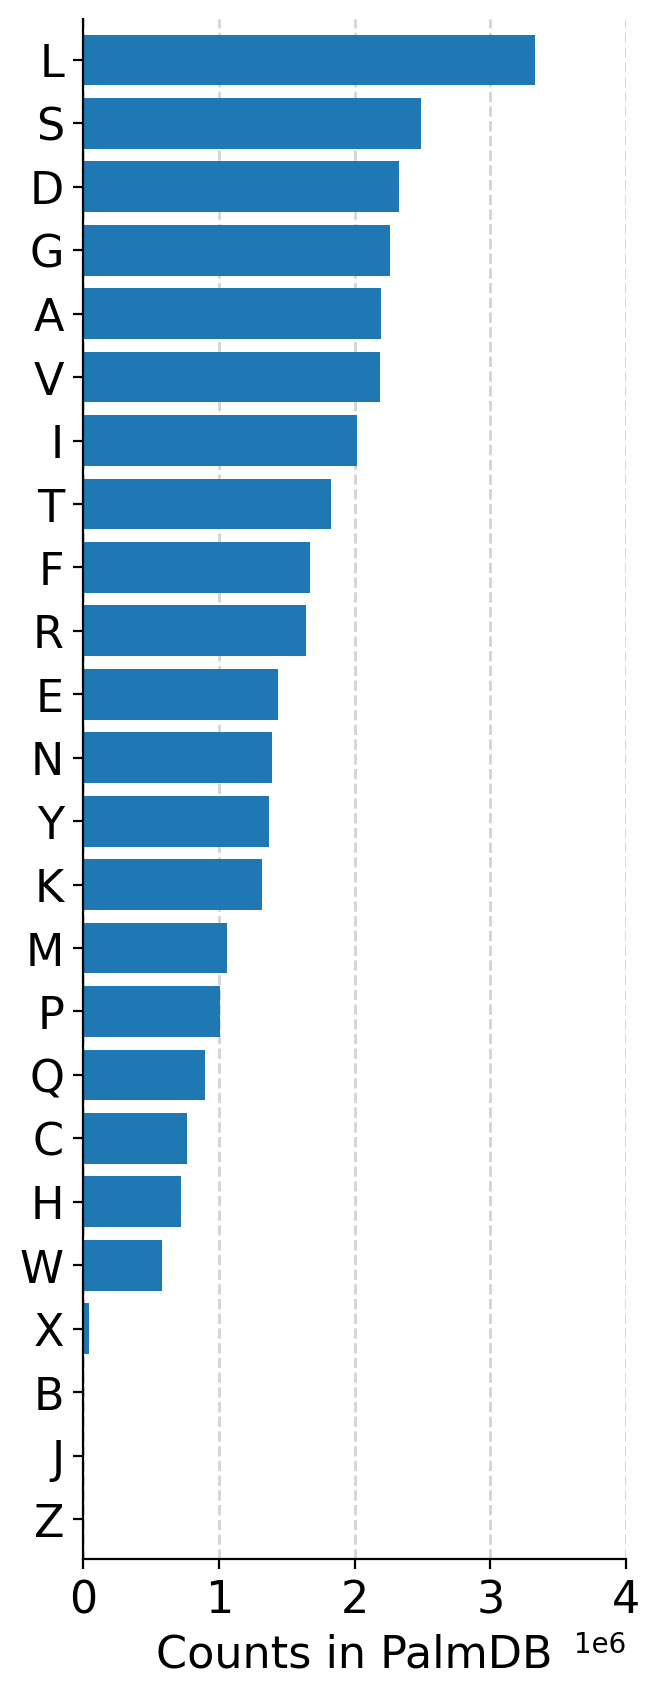

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 10))
fontsize = 16

ax.barh(df["aa"].values, df["aa_count"].values)

ax.set_xlabel("Counts in PalmDB", fontsize=fontsize)

ax.tick_params(axis="both", labelsize=fontsize)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)
ax.yaxis.grid(False)
ax.spines[['right', 'top']].set_visible(False)
ax.margins(y=0.01)

ax.set_xlim(right=4*10**6)
plt.gca().invert_yaxis()

# plt.tight_layout()
plt.savefig("palmdb_char_counts.png", dpi=300, bbox_inches="tight")

fig.show()

### Plot Hamming distance between amino acids after reverse translation into comma free code:

In [8]:
# comma-free code AA dictionary
cfcode = {
    "F": "ACC",
    "L": "ACA",
    "I": "ATA",
    "M": "ATC",
    "V": "ATT",
    "S": "CTA",
    "P": "CTC",
    "T": "CTT",
    "A": "AGA",
    "Y": "AGC",
    "H": "AGT",
    "Q": "AGG",
    "N": "CGA",
    "K": "CGC",
    "D": "CGT",
    "E": "CGG",
    "C": "TGA",
    "W": "TGC",
    "R": "TGT",
    "G": "TGG",
    "X": "NNN",  # Amino acid not known
    "B": "CGT",  # Represents either N or D - will translate as D here (N is only off by one base)
    "J": "ACA",  # Represents either L or I - will translate as L here (I is only off by one base)
    "Z": "CGG"   # Represents either E or Q - will translate as E here (Q is only off by one base)
}

Plot Hamming distances between amino acids:

In [9]:
# Get distances between amino acids
n = len(df["aa"].values)
hamming_mtx = np.zeros((n,n))

for x_idx, aa1 in enumerate(df["aa"].values):
    for y_idx, aa2 in enumerate(df["aa"].values):
        hamming_mtx[x_idx, y_idx] = hamming(list(cfcode[aa1]), list(cfcode[aa2])) * 3

<ipython-input-10-24924e402bcc>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = matplotlib.cm.get_cmap("Reds_r")


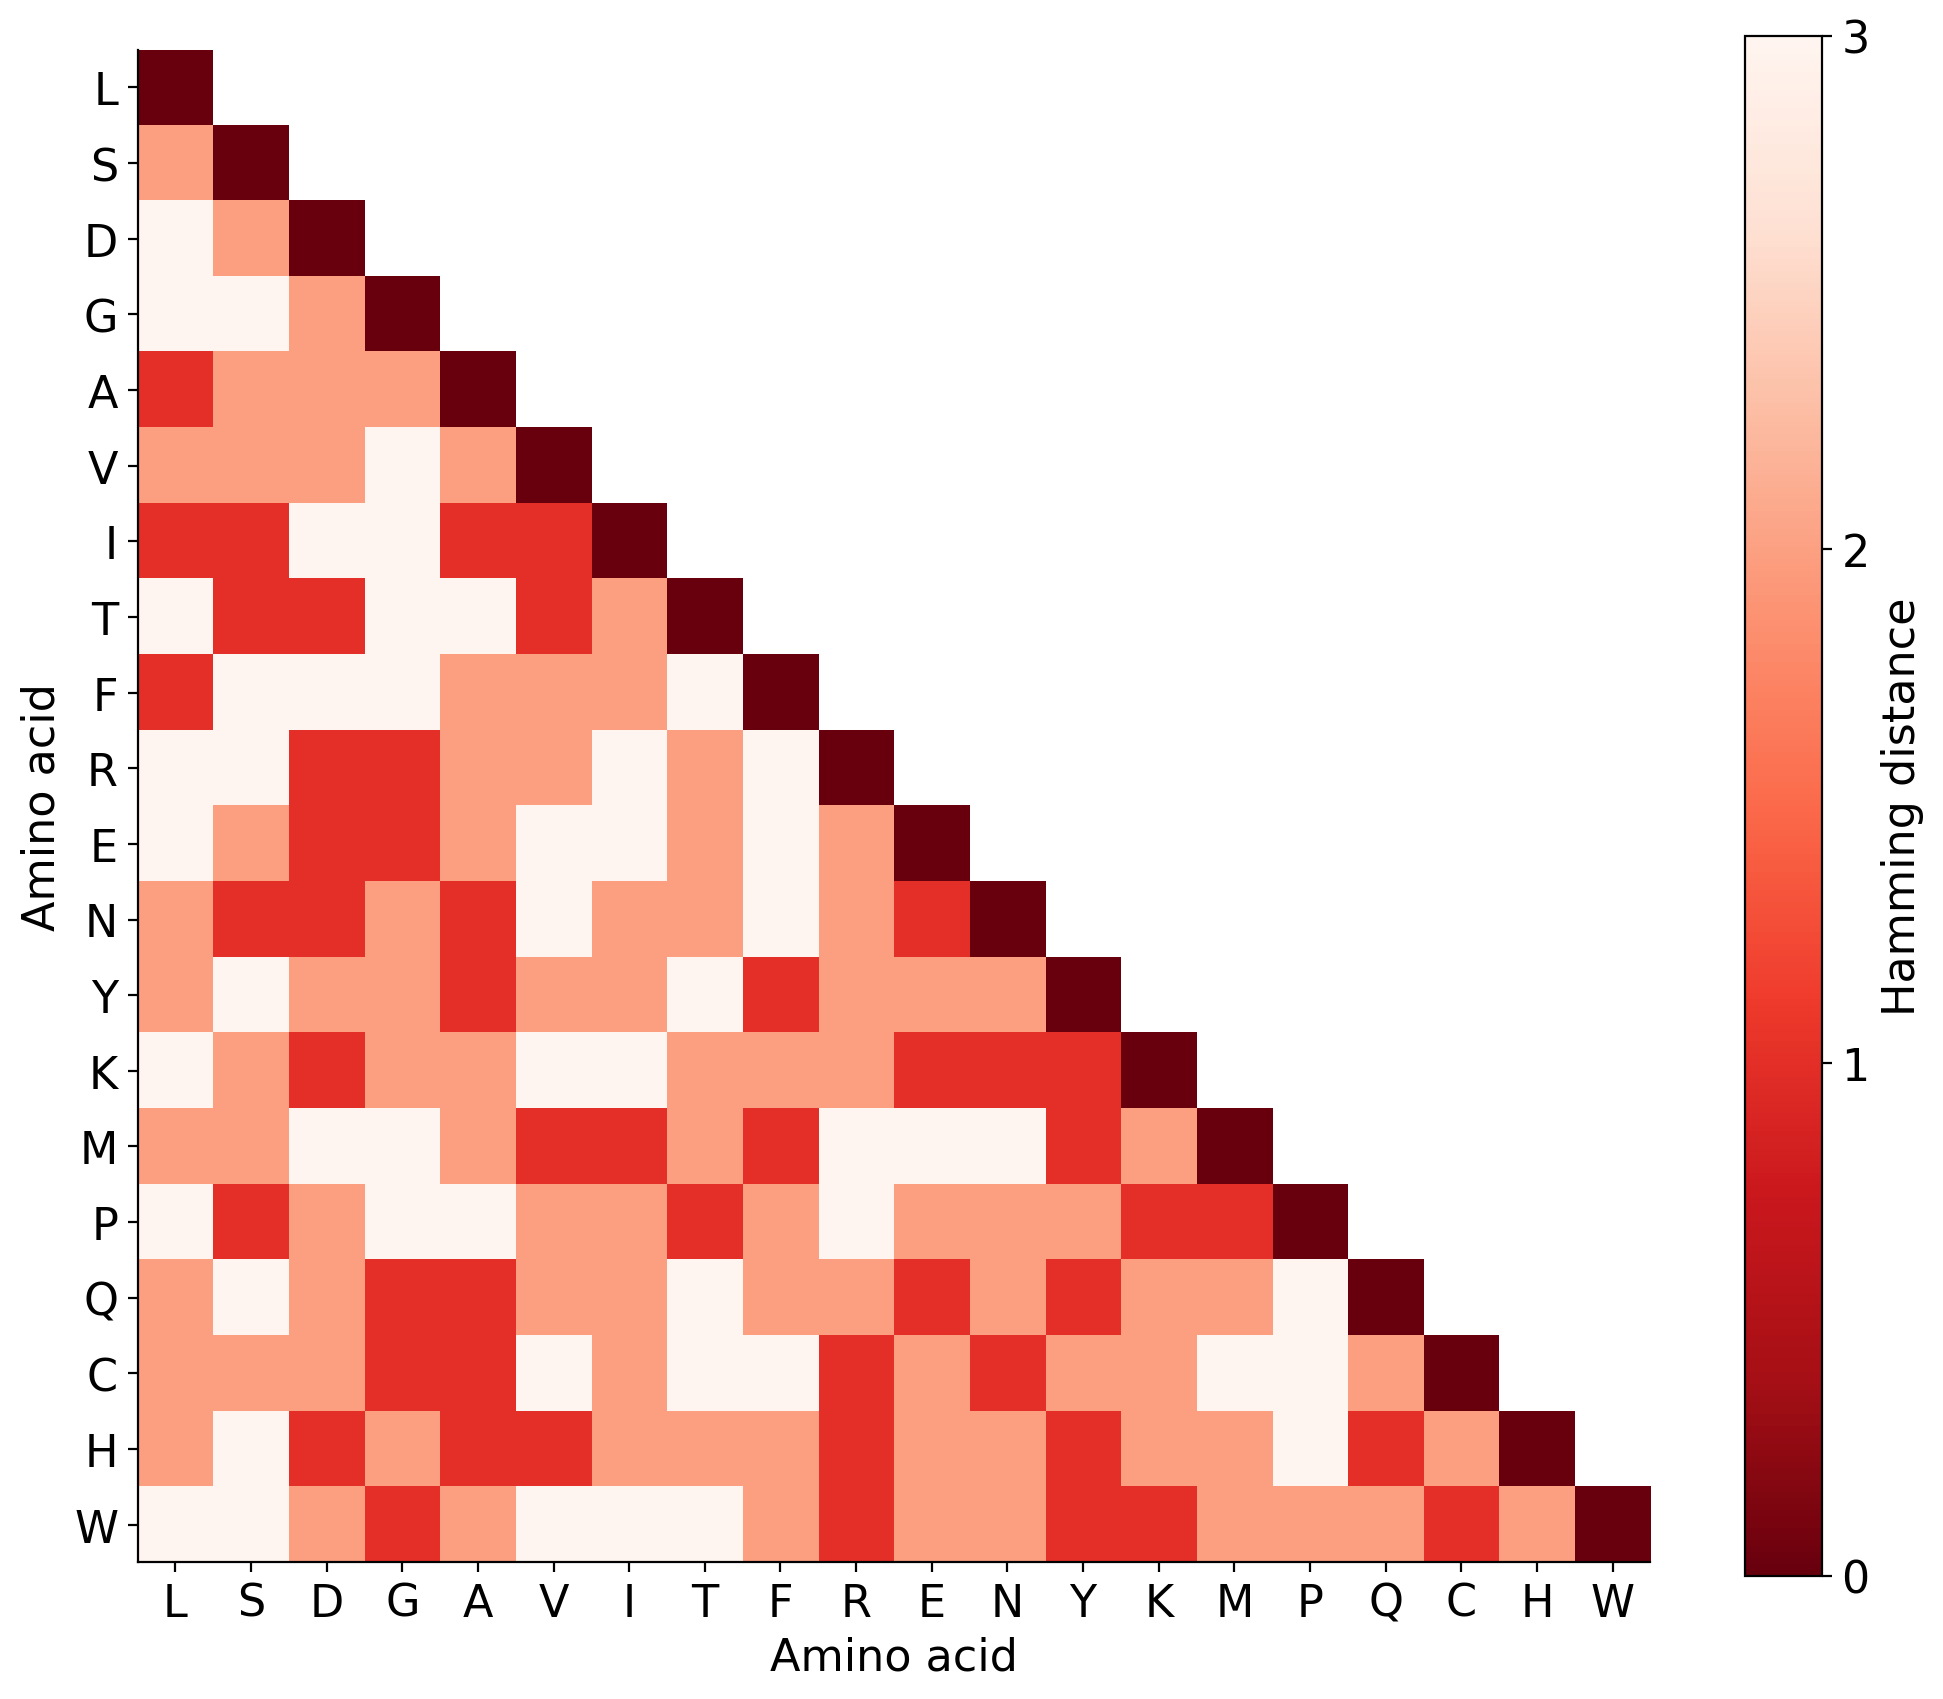

In [10]:
fig, ax = plt.subplots(figsize=(12.2, 10))
fontsize = 16

mask = np.tri(hamming_mtx.shape[0], k=-1)
data = np.ma.array(hamming_mtx, mask=mask)

cmap_reversed = matplotlib.cm.get_cmap("Reds_r")
im = ax.imshow(data.T[:-4, :-4], cmap=cmap_reversed)
cbar = fig.colorbar(im, ax=ax, ticks=[0, 1, 2 ,3])
cbar.set_label("Hamming distance", fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

ax.spines[['right', 'top']].set_visible(False)

ax.set_xticks(np.arange(len(df["aa"].values)-4))
ax.set_yticks(np.arange(len(df["aa"].values)-4))
ax.set_xticklabels(df["aa"].values[:-4])
ax.set_yticklabels(df["aa"].values[:-4])

ax.set_ylabel("Amino acid", fontsize=fontsize)
ax.set_xlabel("Amino acid", fontsize=fontsize)

ax.tick_params(axis="both", labelsize=fontsize)

plt.savefig("cfc_hamming_dists.png", dpi=300, bbox_inches="tight", transparent=True)

fig.show()

### Generate a new code where amino acids that occur more often have a larger Hamming distance ('max ham code'):

In [11]:
max_ham_code = {
    'L': "GGG",
    'S': "TTC",
    'D': "CTA",
    'G': "GCT",
    'A': "TCG",
    'V': "AGC",
    'I': "GTG",
    'T': "GAC",
    'F': "TAG",
    'R': "ATG",
    'E': "CGA",
    'N': "GTA",
    'Y': "TAC",
    'K': "CAT",
    'M': "CAG",
    'P': "AGT",
    'Q': "TGA",
    'C': "CGT",
    'H': "GCA",
    'W': "ACT",
    "X": "NNN",  # Amino acid not known
    "B": "CTA",  # Represents either N or D - will translate as D here (N is only off by one base)
    "J": "GGG",  # Represents either L or I - will translate as L here (I is only off by one base)
    "Z": "CGA"   # Represents either E or Q - will translate as E here (Q is only off by one base)
}

In [12]:
n = len(df["aa"].values)
hamming_mtx = np.zeros((n,n))

for x_idx, aa1 in enumerate(df["aa"].values):
    for y_idx, aa2 in enumerate(df["aa"].values):
        hamming_mtx[x_idx, y_idx] = hamming(list(max_ham_code[aa1]), list(max_ham_code[aa2])) * 3

<ipython-input-13-78eac7486ff1>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = matplotlib.cm.get_cmap("Reds_r")


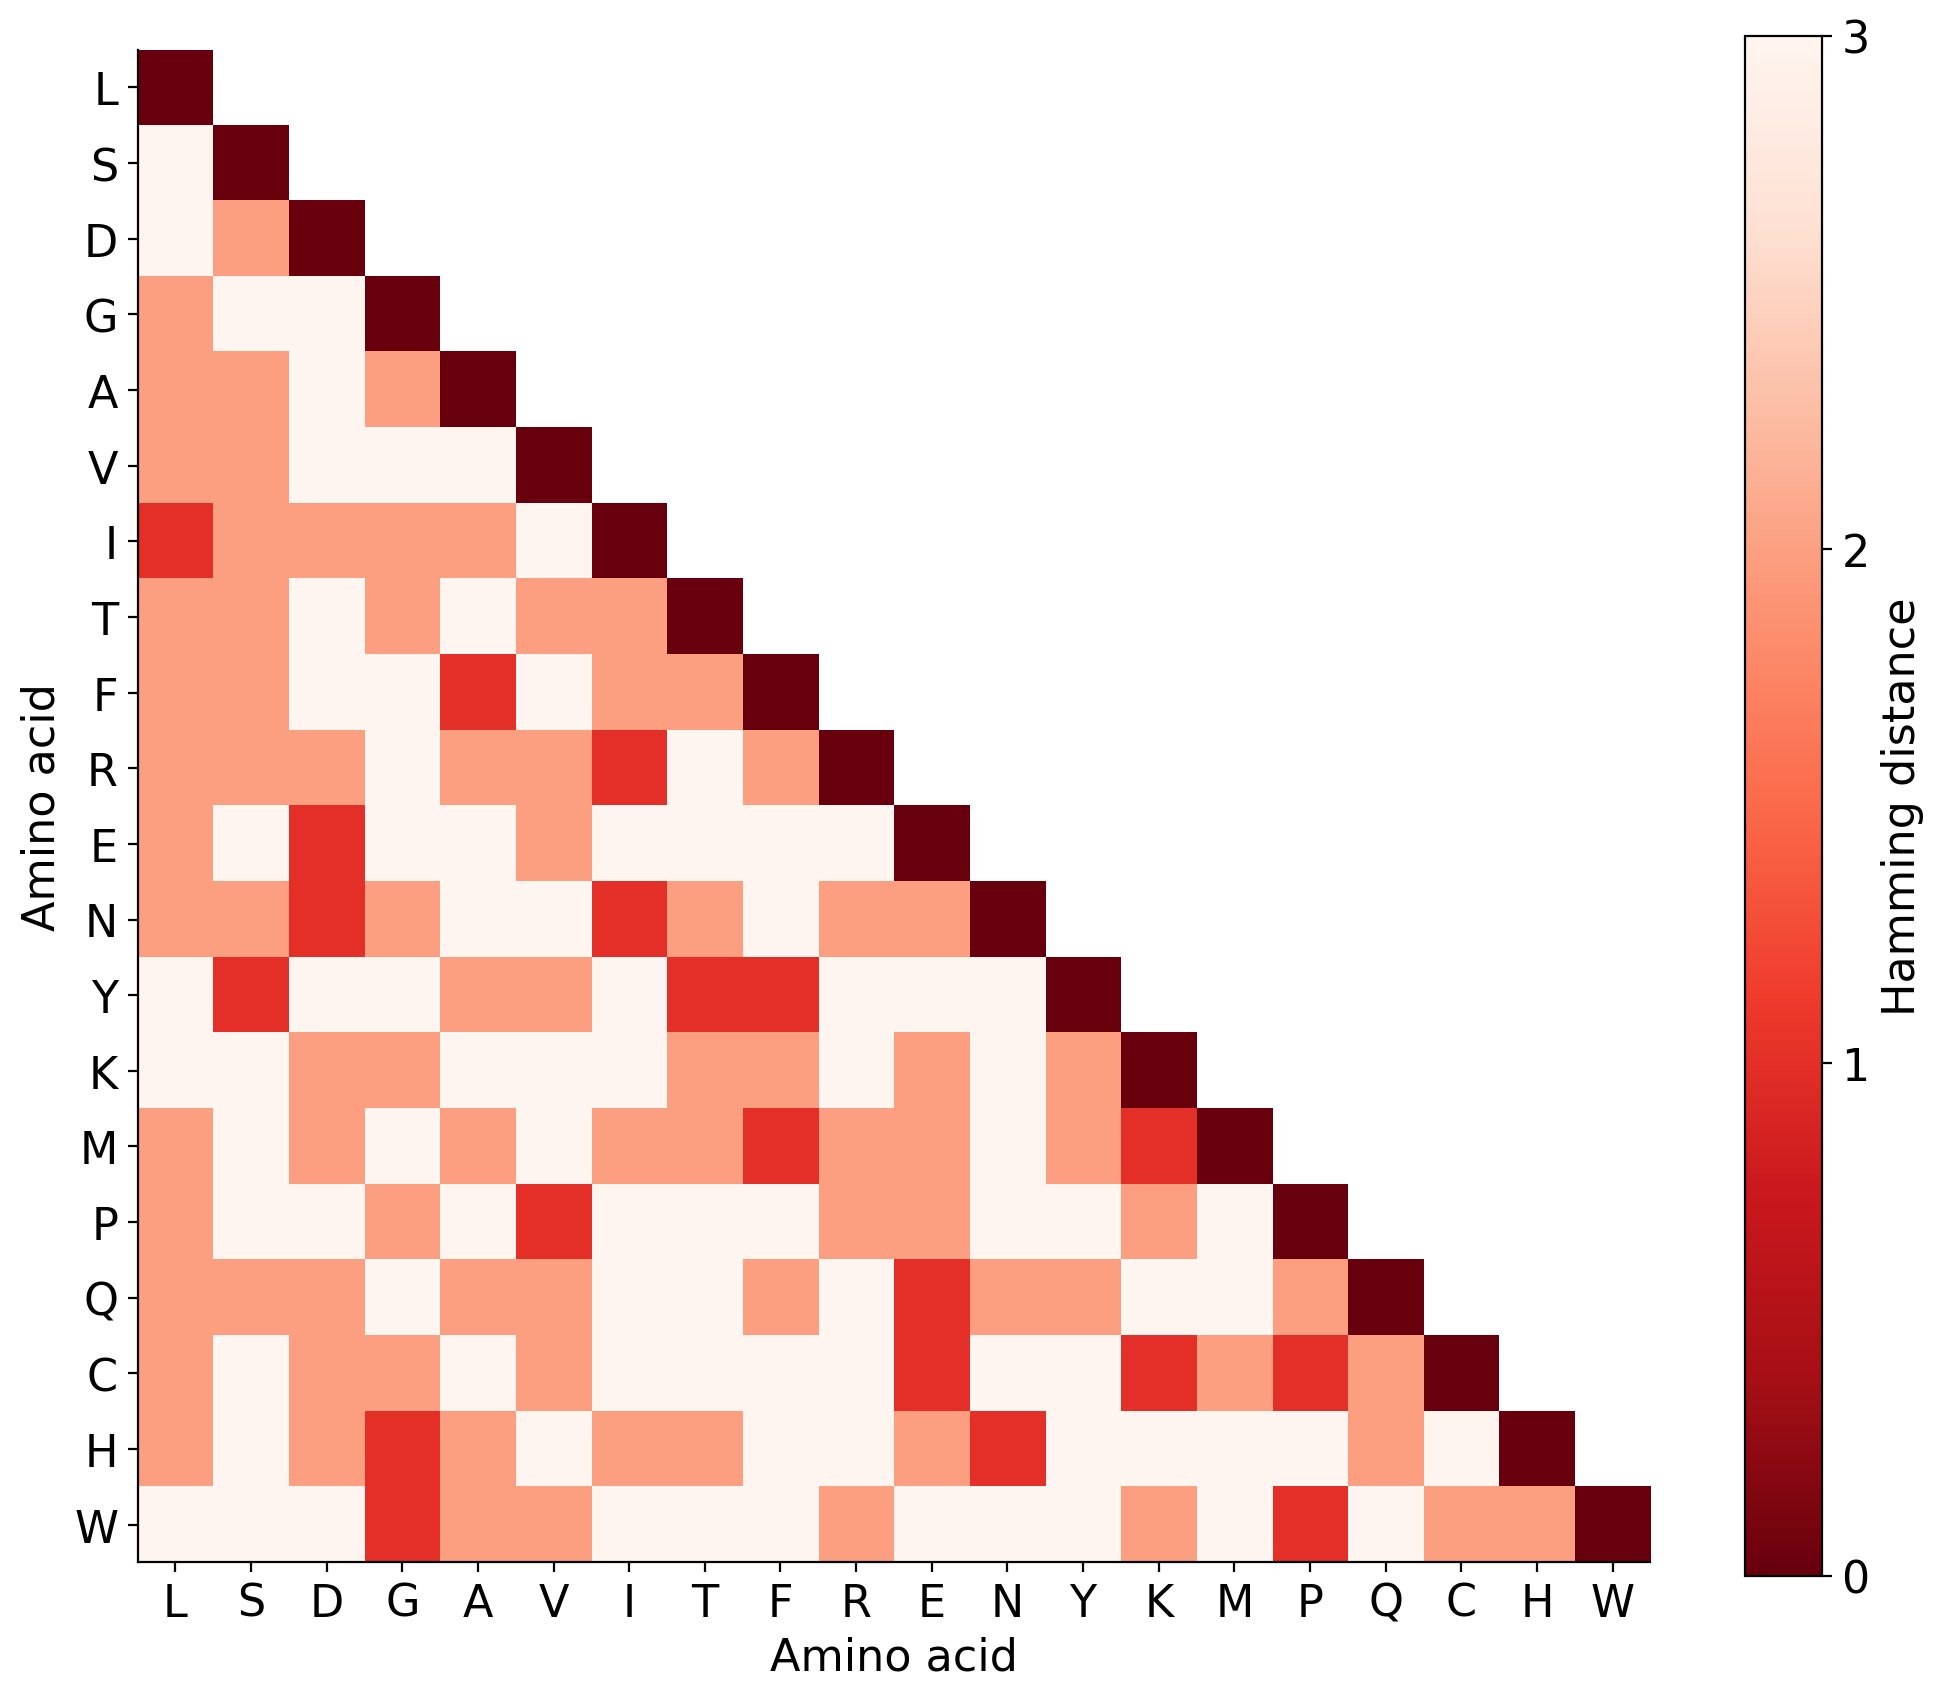

In [13]:
fig, ax = plt.subplots(figsize=(12.2, 10))
fontsize = 16

mask = np.tri(hamming_mtx.shape[0], k=-1)
data = np.ma.array(hamming_mtx, mask=mask)

cmap_reversed = matplotlib.cm.get_cmap("Reds_r")
im = ax.imshow(data.T[:-4, :-4], cmap=cmap_reversed)
cbar = fig.colorbar(im, ax=ax, ticks=[0, 1, 2 ,3])
cbar.set_label("Hamming distance", fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

ax.spines[["right", "top"]].set_visible(False)

ax.set_xticks(np.arange(len(df["aa"].values)-4))
ax.set_yticks(np.arange(len(df["aa"].values)-4))
ax.set_xticklabels(df["aa"].values[:-4])
ax.set_yticklabels(df["aa"].values[:-4])

ax.tick_params(axis="both", labelsize=fontsize)

ax.set_ylabel("Amino acid", fontsize=fontsize)
ax.set_xlabel("Amino acid", fontsize=fontsize)

plt.savefig("max_ham_code_hamming_dists.png", dpi=300, bbox_inches="tight", transparent=True)

fig.show()